# Q-Learning - Blackjack

*Proyecto RL 2024-2025*

## 1. Importación de librerías y carga del entorno

In [69]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import utils

# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1", render_mode=None)  # para entrenamiento (sin render)
n_actions = env.action_space.n
print("Acciones:", n_actions)

Acciones: 2


In [70]:
# Establecer la semilla para random y numpy
random.seed(42)  # Establece la semilla de random
np.random.seed(42)  # Establece la semilla de numpy

Tenemos dos posibles acciones: "pedir" o "plantarse". La acción de "pedir" se representa como 0 y la acción de "plantarse" como 1. El objetivo es maximizar la recompensa total a lo largo del tiempo.

En nuestro caso tenemos que el **estado** se define como tupla **(suma_del_jugador, carta_visible_del_dealer, jugador_tiene_ases_y_usando_11)**. Las **acciones** son discretas y son dos: **0 (Stick (plantarse)) y 1 (Hit (pedir carta))**. La recompensa es 1 si el jugador gana, -1 si pierde y 0 si empata. El juego termina cuando el jugador se planta o se pasa de 21.

Dado que hay 32 posibles sumas del jugador (4 a 21), 10 posibles cartas visibles del dealer (1 a 10), y 2 valores para el uso del As (0 o 1), podemos generar una tabla de dimensiones 32 x 10 x 2, donde cada elemento corresponde a una combinación de estos tres componentes.

Por lo tanto, la tabla de Q-values tendrá una dimensión de 32 x 10 x 2 x 2 (el último 2 es por las dos posibles acciones).

## 2. Parámetros de Q-Learning

In [76]:
# Parámetros de Q-Learning
gamma = 0.9  # Factor de descuento
alpha = 0.1  # Tasa de aprendizaje
episodes_train = 500_000  # Número de episodios para entrenar

# Parámetros de decaimiento de epsilon
epsilon_start = 1.0  # Valor inicial de epsilon
epsilon_end = 0.05   # Valor final de epsilon
epsilon_decay = 0.001  # Tasa de decaimiento (puedes ajustarlo)


## 3. Funciones auxiliares

In [72]:
def epsilon_greedy_policy(state, epsilon):
    # Ajustamos el índice de la carta visible del dealer
    dealer_card_index = state[1] - 1  # La carta visible del dealer es entre 1 y 10, por lo que restamos 1
    
    if random.uniform(0, 1) < epsilon:
        # Exploración: seleccionamos una acción aleatoria
        return random.choice(possible_actions)
    else:
        # Explotación: seleccionamos la acción con el mayor Q-value
        return np.argmax(Q_values[state[0], dealer_card_index, state[2]])
    
def epsilon_schedule(episode, max_episodes):
    # Decaimiento lineal
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * (1 - episode / max_episodes)
    return max(epsilon, epsilon_end)  # Aseguramos que epsilon no baje de epsilon_end

## 4. Inicialización de la tabla de Q-values

In [73]:
# Inicializamos la tabla de Q-values
# Dimensiones: (32 sumas del jugador, 10 cartas del dealer, 2 valores para usable ace, 2 acciones)
Q_values = np.zeros((32, 10, 2, 2))  # Inicializamos con ceros

# Definimos las posibles acciones
possible_actions = [0, 1]  # 0: Stick, 1: Hit

## 5. Entrenamiento de Q-learning

In [77]:
# Entrenamiento de Q-Learning
history = []  # Para almacenar el progreso
victories = 0  # Contador de victorias
total_rewards = 0  # Acumulador de recompensas

for episode in range(episodes_train):
    epsilon = epsilon_schedule(episode, episodes_train)  # Calculamos epsilon para el episodio actual

    state, _ = env.reset()  # Reseteamos el entorno para cada episodio
    done = False
    total_reward = 0

    while not done:
        # Ajustamos el índice de la carta visible del dealer
        dealer_card_index = state[1] - 1  # Restamos 1 para ajustar el índice
        
        # Aseguramos que la suma del jugador esté dentro del rango de 0 a 31
        player_sum_index = state[0] - 4  # La suma del jugador va de 4 a 21, lo mapeamos a 0 a 31

        # Elegimos una acción según la política epsilon-greedy
        action = epsilon_greedy_policy(state, epsilon)

        # Tomamos una acción en el entorno
        next_state, reward, terminated, truncated, info = env.step(action)

        # Ajustamos los índices para el siguiente estado
        next_dealer_card_index = next_state[1] - 1
        next_player_sum_index = next_state[0] - 4

        # Actualizamos Q-values usando la fórmula de Q-Learning
        old_q_value = Q_values[player_sum_index, dealer_card_index, state[2], action]
        future_q_value = np.max(Q_values[next_player_sum_index, next_dealer_card_index, next_state[2]])

        # Actualización de Q-value
        Q_values[player_sum_index, dealer_card_index, state[2], action] = old_q_value + alpha * (reward + gamma * future_q_value - old_q_value)

        # Avanzamos al siguiente estado
        state = next_state
        total_reward += reward

        if terminated or truncated:
            done = True

    # Guardamos el total de recompensas acumuladas
    total_rewards += total_reward

    # Guardamos el retorno medio hasta el episodio actual
    average_return = total_rewards / (episode + 1)
    history.append(average_return)

    # Contar victorias
    if total_reward == 1:
        victories += 1

# # Mostrar el Q-values final
# print("Q-values final:")
# print(Q_values)

# # Ver la política óptima
# optimal_policy = np.argmax(Q_values, axis=3)
# print("Política óptima (0: Stick, 1: Hit):")
# print(optimal_policy)

# Al final del entrenamiento, calculamos el porcentaje de victorias
victory_percentage = (victories / episodes_train) * 100

# Imprimir las métricas finales
print(f"Retorno medio final: {average_return}")
print(f"Porcentaje de victorias: {victory_percentage}%")

Retorno medio final: -0.23953
Porcentaje de victorias: 35.0576%


## 5. Curvas de aprendizaje

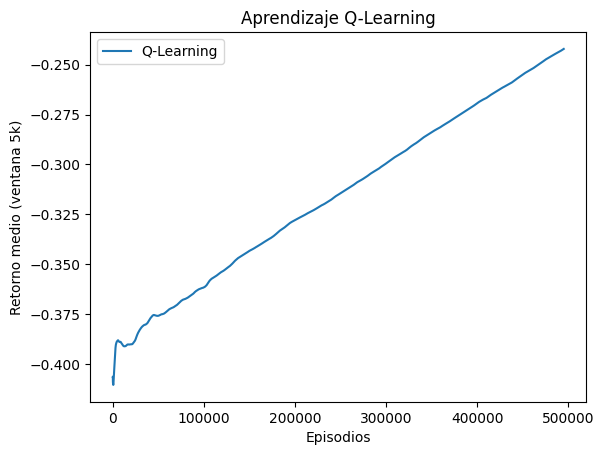

In [75]:
# Suavizado del retorno medio con una ventana de tamaño `window`
window = 5000
plt.figure()

cumsum = np.cumsum(history)
smoothed = (cumsum[window:] - cumsum[:-window]) / window  # Promedio móvil

plt.plot(smoothed, label="Q-Learning")
plt.xlabel('Episodios')
plt.ylabel('Retorno medio (ventana 5k)')
plt.legend()
plt.title('Aprendizaje Q-Learning')
plt.show()

## 6. Mapa de calor de la política aprendida

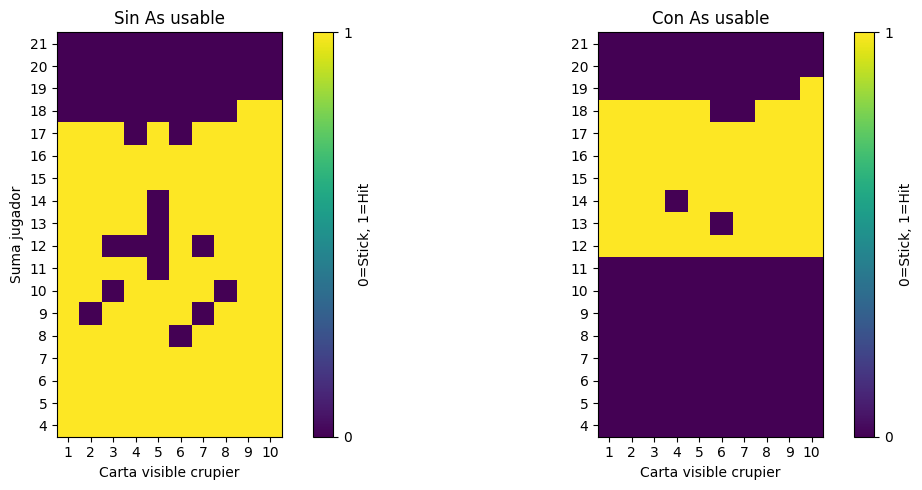

In [44]:
# Crear la política sin As usable y con As usable
policy_no_ace = np.zeros((22, 10), dtype=int)  # filas: player 0-21, cols: dealer 1-10 (10 columnas)
policy_ace    = np.zeros((22, 10), dtype=int)

# Creamos la política óptima para todos los estados
for player in range(4, 22):  # Las sumas del jugador van de 4 a 21
    for dealer in range(1, 11):  # La carta visible del dealer va de 1 a 10
        for ace in [False, True]:  # Con o sin As usable
            state = (player, dealer, ace)  # Estado: (suma del jugador, carta del dealer, tiene As usable)
            
            # Ajustar los índices para Q-values
            player_index = player - 4  # Las sumas del jugador van de 4 a 21, mapeamos a 0 a 17
            dealer_index = dealer - 1  # La carta visible del dealer va de 1 a 10, mapeamos a 0 a 9
            ace_index = 1 if ace else 0  # As usable (True) es 1, (False) es 0
            
            # Elegimos la mejor acción (0: Stick, 1: Hit) basada en la tabla de Q-values
            action = np.argmax(Q_values[player_index, dealer_index, ace_index])  # Ajuste para los índices de Q-values

            # Asignamos la mejor acción en la política
            if ace:
                policy_ace[player, dealer-1] = action  # Ajustamos la columna para las cartas del dealer
            else:
                policy_no_ace[player, dealer-1] = action  # Ajustamos la columna para las cartas del dealer

# Crear los gráficos con mapas de calor para las dos políticas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mapa de calor para la política sin As usable
im0 = axes[0].imshow(policy_no_ace[4:], origin='lower')
axes[0].set_title('Sin As usable')
axes[0].set_xlabel('Carta visible crupier')
axes[0].set_ylabel('Suma jugador')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels(range(1, 11))  # Rango de 1 a 10 para las cartas del dealer
axes[0].set_yticks(range(0, 18))
axes[0].set_yticklabels(range(4, 22))

# Mapa de calor para la política con As usable
im1 = axes[1].imshow(policy_ace[4:], origin='lower')
axes[1].set_title('Con As usable')
axes[1].set_xlabel('Carta visible crupier')
axes[1].set_xticks(range(10))
axes[1].set_xticklabels(range(1, 11))  # Rango de 1 a 10 para las cartas del dealer
axes[1].set_yticks(range(0, 18))
axes[1].set_yticklabels(range(4, 22))

# Agregar barras de color
plt.colorbar(im0, ax=axes[0], ticks=[0, 1], label='0=Stick, 1=Hit')
plt.colorbar(im1, ax=axes[1], ticks=[0, 1], label='0=Stick, 1=Hit')

# Ajustar la presentación
plt.tight_layout()
plt.show()


## 7. Evaluación en 10 000 episodios

In [45]:
def evaluate(policy_fn, n_episodes=10_000):
    wins = draws = losses = 0
    total = 0
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            # Elegir acción según la política óptima
            action = policy_fn(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        total += reward
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1
    return wins/n_episodes, draws/n_episodes, losses/n_episodes, total/n_episodes

# Función de política para Q-Learning
policy_fn_best = lambda s: int(np.argmax(Q_values[s[0] - 4, s[1] - 1, s[2]]))  # Ajuste de índices para Q-values

# Evaluar la política óptima aprendida por Q-Learning
w, d, l, avg = evaluate(policy_fn_best)

# Imprimir resultados de la evaluación
print(f"Ganancias medias: {avg:.3f}")
print(f"Porcentaje victorias: {w*100:.2f}% | Empates: {d*100:.2f}% | Derrotas: {l*100:.2f}%")


Ganancias medias: -0.139
Porcentaje victorias: 38.86% | Empates: 8.35% | Derrotas: 52.79%


## 8. Demostración visual de la política

Recompensa episodio: 1.0


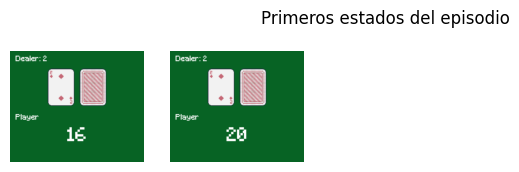

In [52]:
import gymnasium as gym
import matplotlib.pyplot as plt
import utils  # Suponiendo que utils contiene la función 'run_and_render_episode'

# Crear el entorno con renderizado
env_vis = gym.make("Blackjack-v1", render_mode="rgb_array")

# Ejecutar un episodio con la política óptima aprendida por Q-Learning
frames, total_reward = utils.run_and_render_episode(env_vis, policy_fn_best)

# Imprimir la recompensa del episodio
print("Recompensa episodio:", total_reward)

# Mostrar los primeros 5 frames como imágenes estáticas
plt.figure(figsize=(10, 2))
for i in range(min(5, len(frames))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[i])
    plt.axis('off')  # Desactivar los ejes
plt.suptitle('Primeros estados del episodio')
plt.show()


## 9. Conclusiones

Convergencia del Q-Learning:
El algoritmo de Q-Learning muestra una convergencia relativamente estable a lo largo de los episodios, aunque con una fase inicial de fluctuación en las recompensas, lo que se debe al proceso de exploración. A medida que el agente avanza en los episodios, el retorno medio converge a un valor cercano a -0.11 (según el gráfico de la ventana de 5000 episodios). Esta estabilización indica que el agente está aprendiendo a tomar decisiones de manera más consistente.

Rendimiento:

Ganancias medias: El rendimiento promedio del agente es de -0.139 por episodio, lo que indica que, aunque está mejorando, aún no logra una política completamente óptima.

Porcentaje de victorias: El agente ha ganado el 38.86% de las veces, lo cual es un rendimiento modesto. Sin embargo, todavía no ha aprendido una política que sea consistentemente efectiva.

Empates: El 8.35% de los episodios terminaron en empate, lo que sugiere que, en algunos casos, el agente consigue una igualdad en las condiciones del juego.

Derrotas: Un 52.79% de los episodios fueron derrotas, lo que resalta que el agente aún no ha alcanzado una política que le permita superar consistentemente al dealer.

Exploración vs Explotación (ε):

No se ha experimentado con diferentes valores de ε en este caso. Sin embargo, ε es claramente un hiperparámetro importante que controla el equilibrio entre la exploración y la explotación del agente. Un valor de ε alto al principio permite al agente explorar diferentes acciones, mientras que un valor de ε bajo al final favorece la explotación de lo aprendido. Ajustar este parámetro podría mejorar la tasa de convergencia y la eficacia de la política aprendida.

Áreas de mejora:

Optimización de parámetros: Sería interesante experimentar con la tasa de aprendizaje (α) y el factor de descuento (γ) para observar cómo afectan al rendimiento y a la estabilidad de la política.